In [1]:
#Reference: Heng CherKeng https://storage.googleapis.com/kaggle-forum-message-attachments/345216/9642/train.py
    
import os
from trackml.score  import score_event
from sklearn.cluster.dbscan_ import dbscan
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from keras import models
from keras import layers



TRAIN_DATA = '../../../input/train_100_events'

/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [97]:
def load_one_event_data(event_id):
    
    particles = pd.read_csv(os.path.join(TRAIN_DATA, 'event%s-particles.csv'%event_id))
    hits  = pd.read_csv(os.path.join(TRAIN_DATA, 'event%s-hits.csv' %event_id))
    truth = pd.read_csv(os.path.join(TRAIN_DATA, 'event%s-truth.csv'%event_id))
    cells = pd.read_csv(os.path.join(TRAIN_DATA, 'event%s-cells.csv'%event_id))

    truth = truth.merge(hits,       on=['hit_id'],      how='left')
    truth = truth.merge(particles,  on=['particle_id'], how='left')

    #--------------------------------------------------------
    df = truth
    return (df)

#TODO x,y,z<0
def generate_train_batch(df):
     # ..........................................
    # use volume feature in "x,y,z > 0" only
    df = df.copy()
    df = df.loc[ (df.x>0) & (df.y>0) & (df.z>0) ]
    df = df.assign(r   = np.sqrt( df.x**2 + df.y**2))
    df = df.assign(d   = np.sqrt( df.x**2 + df.y**2 + df.z**2 ))
    df = df.assign(a   = np.arctan2(df.y, df.x))
    df = df.assign(cosa= np.cos(df.a))
    df = df.assign(sina= np.sin(df.a))
    df = df.assign(phi = np.arctan2(df.z, df.r))
    N  = len(df)

    a,r,z = df[['a', 'r', 'z' ]].values.astype(np.float32).T
    p = df['particle_id'].values.astype(np.int64)
    
    particle_ids = list(df.particle_id.unique())
    num_particle_ids = len(particle_ids)
    
    input  = np.column_stack((a,r/1000, z/3000))
    tracks = []
    
    for particle_id in particle_ids:
        if particle_id==0: continue
        t = np.where(p==particle_id)[0]
        t = t[np.argsort(r[t])]

        #TODO 
        if len(t)<10: continue
        track = input[t[:10]]
        tracks.append(track)

    tracks = np.array(tracks)
    input  = tracks
    truth  = tracks[:,:,:]

    return (df, input, truth)




In [98]:
def batch_generator(input, truth, batch_size):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, input.shape[0], input.shape[1]))
    batch_labels =  np.zeros((batch_size, input.shape[0], input.shape[1]))
    index = 0
   
    while True:
        batch_features = input[batch_size*index:batch_size*(index+1),:,:]
        batch_labels = batch_features
        index = index+1
        if batch_size*index > input.shape[0]:
            index=0
      
        yield batch_features, batch_labels



In [119]:
def build_model(num_hidden, det_shape,
                loss='mse',
                optimizer='Nadam', metrics=['accuracy']):
    
    inputs = layers.Input(shape=det_shape)
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    outputs = layers.TimeDistributed(layers.Dense(det_shape[1], activation='linear'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [91]:
def draw_train_history(history, draw_val=True, figsize=(12,5)):
    """Make plots of training and validation losses and accuracies"""
    fig = plt.figure(figsize=figsize)
    # Plot loss
    plt.subplot(121)
    plt.plot(history.epoch, history.history['loss'], label='Training set')
    if draw_val:
        plt.plot(history.epoch, history.history['val_loss'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.epoch, history.history['acc'], label='Training set')
    if draw_val:
        plt.plot(history.epoch, history.history['val_acc'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim((0, 1))
    plt.title('Training accuracy')
    plt.legend(loc=0)
    plt.tight_layout()
    return fig



In [126]:
def draw_prediction(input, predict):
   
    fig1 = plt.figure(figsize=(12,12))
    ax1  = fig1.add_subplot(111, projection='3d')
    fig1.patch.set_facecolor('white')
    ax1.set_xlabel('x', fontsize=16)
    ax1.set_ylabel('y', fontsize=16)
    ax1.set_zlabel('z', fontsize=16)
        

    fig2 = plt.figure(figsize=(12,12))
    ax2  = fig2.add_subplot(111, projection='3d')
    fig2.patch.set_facecolor('white')
    ax2.set_xlabel('a', fontsize=16)
    ax2.set_ylabel('r', fontsize=16)
    ax2.set_zlabel('z', fontsize=16)

    batch_size = len(predict)
    for n in range(0,batch_size,1):
        a, r, z = input[n].T
        x = r*np.cos(a)
        y = r*np.sin(a)
        
        ea, er, ez = predict[n].T
        ex = er*np.cos(ea)
        ey = er*np.sin(ea)
        
        color = np.random.uniform(0,1,3)
        ax1.plot(ex,ey,ez,'.-',color = [0.75,0.75,0.75], markersize=10)
        ax1.plot(x,y,z,'.-',color = color, markersize=5)
        
        
        ax2.plot(ea,er,ez,'.-',color = [0.75,0.75,0.75], markersize=10)
        ax2.plot(a,r,z,'.-',color = color, markersize=5)
        if n==50: plt.show(1)


   
    

In [108]:
def generate_multiple_event_data(skip=0, nevents=10):
    for i in range(nevents):
        df = load_one_event_data('0000010' + "{:02}".format(skip+i))
        df, input_tmp, _ = generate_train_batch(df)
        if i==0:
            input = input_tmp
        else:
            input = np.concatenate([input, input_tmp])
    return input

(13399, 29)
(13403, 10, 3)
(611, 10, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 10, 3)             0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 10, 24)            2688      
_________________________________________________________________
time_distributed_33 (TimeDis (None, 10, 3)             75        
Total params: 2,763
Trainable params: 2,763
Non-trainable params: 0
_________________________________________________________________


/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=24)`
  
/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ti...)`
  


Epoch 1/10
1340/1340 [==============================] - 10s 7ms/step - loss: 0.0053 - acc: 0.9584
Epoch 2/10
1340/1340 [==============================] - 10s 8ms/step - loss: 1.1067e-04 - acc: 0.9900
Epoch 3/10
1340/1340 [==============================] - 13s 10ms/step - loss: 4.6680e-05 - acc: 0.9936
Epoch 4/10
1340/1340 [==============================] - 13s 10ms/step - loss: 2.8765e-05 - acc: 0.9948
Epoch 5/10
1340/1340 [==============================] - 14s 10ms/step - loss: 1.8133e-05 - acc: 0.9963
Epoch 6/10
1340/1340 [==============================] - 15s 11ms/step - loss: 1.6631e-05 - acc: 0.9971
Epoch 7/10
1340/1340 [==============================] - 13s 10ms/step - loss: 1.2389e-05 - acc: 0.9975
Epoch 8/10
1340/1340 [==============================] - 14s 10ms/step - loss: 9.3745e-06 - acc: 0.9977
Epoch 9/10
1340/1340 [==============================] - 14s 10ms/step - loss: 8.8569e-06 - acc: 0.9978
Epoch 10/10
616/616 [==============================] - 2s 3ms/step
3.8182039110

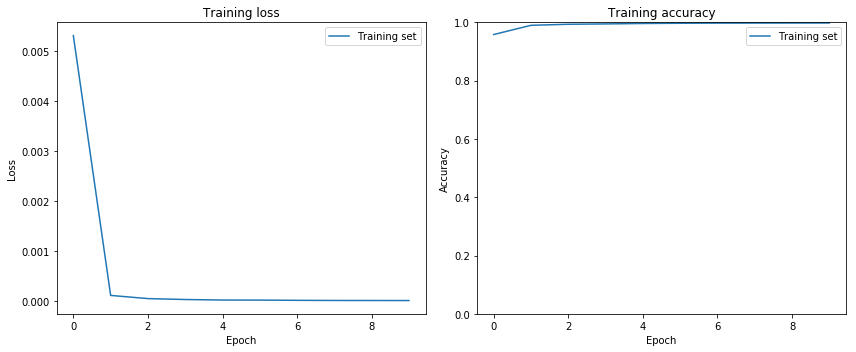

In [120]:
batch_size = 10
num_epoch = 10

if __name__ == '__main__':


    input = generate_multiple_event_data(nevents=20)
    
    test_df = load_one_event_data('000001090')
    test_df, test_input, _ = generate_train_batch(test_df)
    
    
    print(df.shape)
    print(input.shape)
    print(truth.shape)
    
    model = build_model(24, (10,3))

    model.summary()

    generator = batch_generator(input, input, batch_size)
    # Train the model
    history = model.fit_generator(generator, steps_per_epoch=int(input.shape[0]/batch_size), epochs=num_epoch)
    draw_train_history(history, draw_val=False);
    
    pred = model.predict(test_input)
    test_loss, test_acc = model.evaluate(test_input, test_input)
    print(test_loss, test_acc)
    
    


[[1.35621476e+00 3.18370648e-02 1.42919991e-04]
 [1.35609007e+00 3.23391370e-02 1.55208661e-04]
 [1.34134853e+00 7.12478533e-02 1.25826674e-03]
 [1.32606614e+00 1.15009986e-01 2.51522660e-03]
 [1.32529759e+00 1.17050618e-01 2.57645338e-03]
 [1.30510163e+00 1.72383890e-01 4.13630018e-03]
 [1.27131629e+00 2.59525478e-01 6.59999996e-03]
 [1.23466599e+00 3.59038472e-01 9.39999986e-03]
 [1.23253989e+00 3.65043312e-01 9.39999986e-03]
 [1.18064094e+00 5.02497733e-01 1.30000003e-02]]
[[1.3536375  0.03422932 0.0027386 ]
 [1.3556846  0.03136439 0.00146483]
 [1.3416033  0.06930068 0.00197911]
 [1.3263555  0.11305504 0.00351658]
 [1.3241525  0.11563882 0.00357943]
 [1.3054603  0.17115986 0.00496169]
 [1.2723705  0.25868642 0.00682678]
 [1.235505   0.35907844 0.00876866]
 [1.2319753  0.36420217 0.00788205]
 [1.1812534  0.5045301  0.01130258]]


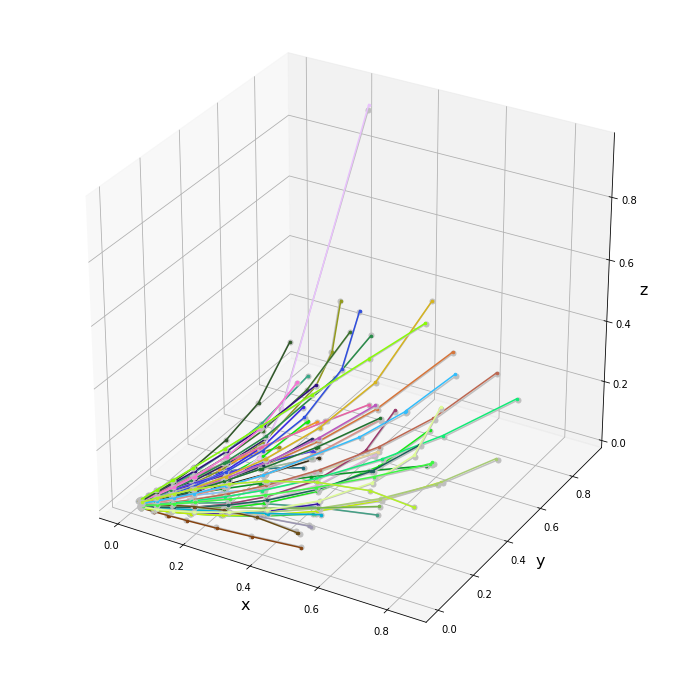

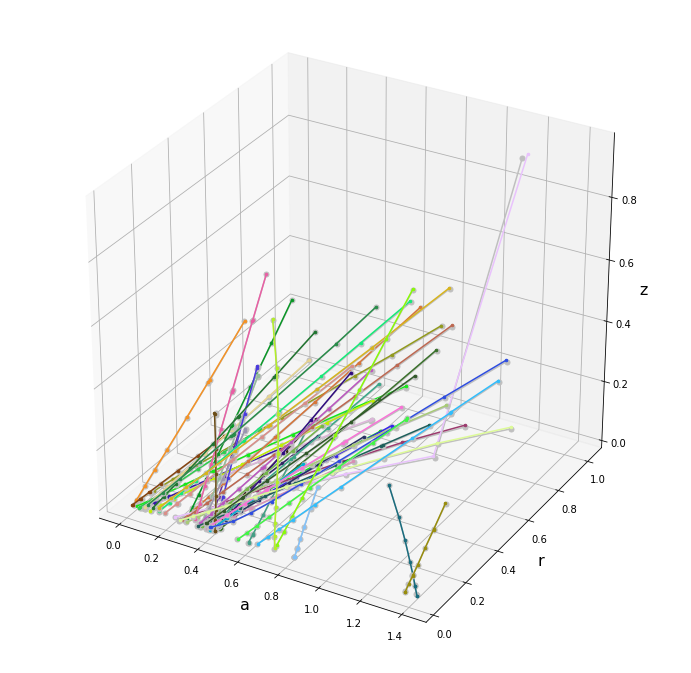

In [127]:
print(test_input[3])
print(pred[3])
   
draw_prediction(test_input, pred)
